In [1]:
import sys
# Python 3.7 is required
assert sys.version_info >= (3,7)

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from util_func import *
import glob
import os
import random

# Make sure that optimization is enabled
if not cv.useOptimized():
    cv.setUseOptimized(True)
    
cv.useOptimized()

True

In [3]:
folder_path = "tsrd-train"

png_files = glob.glob(os.path.join(folder_path, '*.png'))

# Create an empty list to store the images
images = []

# Loop through each PNG file and read it using cv.imread
for png_file in png_files:
    image = cv.imread(png_file)
    
    if image is not None:
        images.append(image)
    else:
        print(f"Unable to read image: {png_file}")

# images' now contains all the PNG images read from the folder.

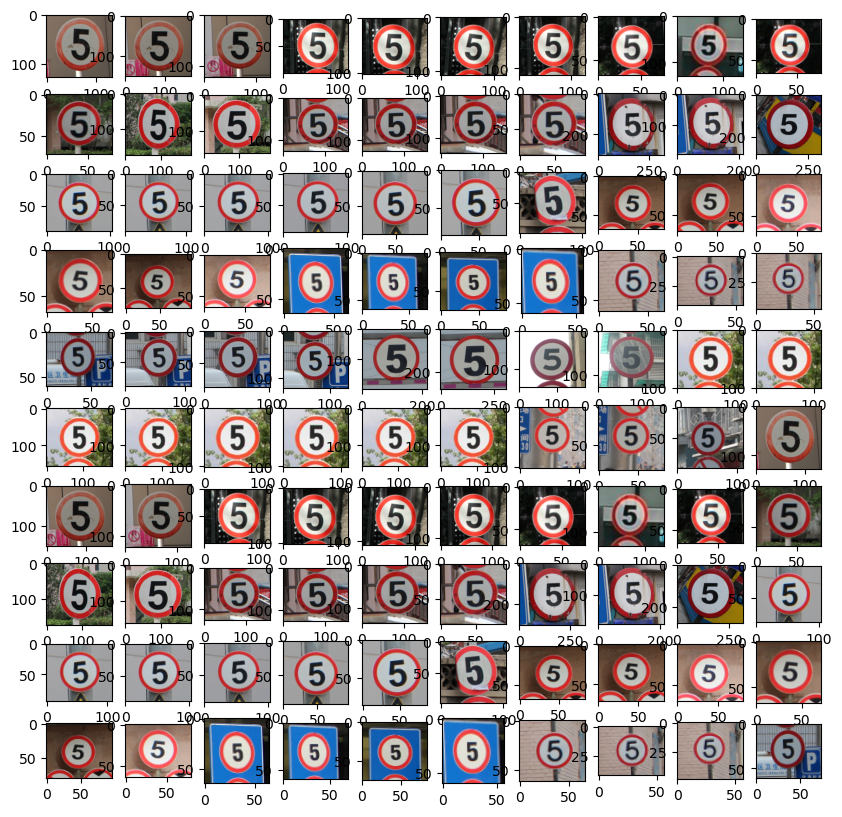

In [4]:
#Display first 100 images
row, col = 10,10

img = []
#Convert images to RGB images
for i in range(0, 100):
    img.append(cv.cvtColor(images[i],cv.COLOR_BGR2RGB))

for i in range(0, 100, row*col):
    fig = plt.figure(figsize = (10,10))
    
    for j in range(0, col*row):
        fig.add_subplot(row, col, j+1)
        plt.imshow(img[i+j])
        
plt.show()

## separate
### can run the code steps by steps

In [5]:
for png_file in png_files:
    random_image_file = random.choice(png_files)
    
# Read the randomly chosen image
image = cv.imread(random_image_file)

if image is not None:
    cv.imshow("Original Image", image)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [6]:
# Convert BGR to LAB
img_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)

# Split the LAB image into L, A, and B channels
l_channel, a_channel, b_channel = cv.split(img_lab)

# Apply CLAHE to the L channel
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clipped_l_channel = clahe.apply(l_channel)

# merge back
enhanced_lab = cv.merge((clipped_l_channel, a_channel, b_channel))

# LAB to BGR
enhanced_rgb = cv.cvtColor(enhanced_lab, cv.COLOR_LAB2BGR)

# BGR to HSV
img_hsv= cv.cvtColor(enhanced_rgb, cv.COLOR_BGR2HSV)

In [7]:
#median Blur
blur_image = cv.medianBlur(img_hsv, 5)
cv.imshow("Original Image", image)
cv.imshow("Smoothed Image", blur_image)
cv.waitKey(0)
cv.destroyAllWindows()

In [9]:
#filter in red
lower_red_1 = np.array([0,50,50])
upper_red_1 = np.array([20, 255, 255])  # Upper limit for first range of red hues
lower_red_2 = np.array([170,50,50])
upper_red_2 = np.array([180, 255, 255])  # Upper limit for second range of red hues
red_mask_1 = cv.inRange(img_hsv, lower_red_1, upper_red_1)
red_mask_2 = cv.inRange(img_hsv, lower_red_2, upper_red_2)
# Combine the two red masks using a bitwise OR operation
red_mask = cv.bitwise_or(red_mask_1, red_mask_2)

#filter in blue
lower_blue1 = np.array([95,150,0])
upper_blue1 = np.array([120,255,255])
b_mask_1 = cv.inRange(img_hsv, lower_blue1, upper_blue1)
lower_blue2 = np.array([94, 127, 20])
upper_blue2 = np.array([126, 255, 200])
b_mask_2 = cv.inRange(img_hsv, lower_blue2, upper_blue2)
blue_mask = cv.bitwise_or(b_mask_1, b_mask_2)

#filter in yellow
lower_yellow = np.array([20, 100, 100])  # Lower limit for yellow hues
upper_yellow = np.array([40, 255, 255])  # Upper limit for yellow hues
yellow_mask = cv.inRange(img_hsv, lower_yellow, upper_yellow)
        
#Combine all the masks
red_mask = cv.resize(red_mask, (img_hsv.shape[1], img_hsv.shape[0]))
blue_mask = cv.resize(blue_mask, (img_hsv.shape[1], img_hsv.shape[0]))
y_mask = cv.resize(yellow_mask, (img_hsv.shape[1], img_hsv.shape[0]))

mask = red_mask | blue_mask | y_mask

In [10]:
# Find contours in the binary mask
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Find the largest contour (assumed to be the traffic sign)
largest_contour = max(contours, key=cv.contourArea)

# Draw a bounding box around the largest contour
x, y, w, h = cv.boundingRect(largest_contour)

cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image with the bounding box
cv.imshow('Image with Bounding Box',image)
cv.waitKey(0)
cv.destroyAllWindows()

In [12]:
img= image.copy()

# Create a black background image
black_background = np.zeros_like(img)

# Draw the largest contour on the black background to create the segmented image
segmented_image = cv.drawContours(black_background, [largest_contour], -1, (255, 255, 255), thickness=cv.FILLED)

# Extract the segmented traffic sign using the segmented mask
segmented_traffic_sign = cv.bitwise_and(img, segmented_image)

# Display the segmented traffic sign
cv.imshow('Segmented Traffic Sign', segmented_traffic_sign)
cv.waitKey(0)
cv.destroyAllWindows()

In [13]:
#Display output
combined_image = np.hstack((img,segmented_traffic_sign))

cv.imshow("Traffic Sign Segmentation", combined_image)
cv.waitKey(0)
cv.destroyAllWindows()

In [14]:
# Specify the path of traffic sign annotation file
file_path = 'TsignRecgTrain4170Annotation.txt'
image_path = random_image_file

# Remove the "tsd-train\\" prefix
image_filename = image_path.split("\\")[-1]

# Print the result
with open(file_path, 'r') as file:
    lines = file.readlines()

parts=""
# Search for the target image filename in the lines
for line in lines:
    parts = line.strip().split(';')
    filename = parts[0]
    if filename == image_filename:
        # Extract the desired values
        x1 = int(parts[3])
        y1 = int(parts[4])
        x2 = int(parts[5])
        y2 = int(parts[6])
        break  # Stop searching once the target is found
gt=[x1,y1,x2,y2]
pred=[x,y,x+w,y+h]

In [15]:
def convert_xywh_to_xyxy(box):
    return [box[0], box[1], box[2], box[3]]
gt_xyxy = convert_xywh_to_xyxy(gt)
pred_xyxy = convert_xywh_to_xyxy(pred)

In [16]:
def computeIOU(boxA,boxB):
    """Args:
    boxA :ground truth
    boxB: prediction They are lists of points"""
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    #compute the intersection area
    interArea = max(0, x_end - x_start + 1) * max(0,y_end - y_start + 1)
    
    #area of box A and box B
    areaA = (boxA[2] - boxA[0] + 1 )* (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1 )* (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)

In [18]:
img_copy = img.copy()
cv.rectangle(img_copy, (gt_xyxy[0], gt_xyxy[1]), (gt_xyxy[2], gt_xyxy[3]), (0, 0, 255), 2)

# Draw the predicted bounding box in blue
cv.rectangle(img_copy, (pred_xyxy[0], pred_xyxy[1]), (pred_xyxy[2], pred_xyxy[3]), (255, 0, 0), 2)

# Compute and display the IOU value
iou = computeIOU(gt, pred)
cv.putText(img_copy, f"IOU: {iou:.3f}", (10, 25), cv.FONT_HERSHEY_PLAIN, 1, (0, 255, 0), 1)
print(f"IOU: {iou:.3f}")
# Show the image with bounding boxes and IOU value
cv.imshow("IOU", img_copy)

# Wait for a key press and then close the window
cv.waitKey(0)
cv.destroyAllWindows()

IOU: 0.963


In [ ]:
#only run this if u want the IOU images to load into your device.
output_folder = "output_images"
image_filename = "image.jpg"
segmented_filename = "segmented_traffic_sign.jpg"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

combined_filename = "combined_image.jpg"
combined_path = os.path.join(output_folder, combined_filename)
cv.imwrite(combined_path, combined_image)

## combined

In [20]:
average_iou = 0
total =0
for i in range(100):
    iou=0
    # Choose a random image from the list of image files
    for png_file in png_files:
        random_image_file = random.choice(png_files)

    # Read the randomly chosen image
    image = cv.imread(random_image_file)
    
    # Convert BGR to LAB
    img_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)

    # Split the LAB image into L, A, and B channels
    l_channel, a_channel, b_channel = cv.split(img_lab)

    # Apply CLAHE to the L channel
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clipped_l_channel = clahe.apply(l_channel)

    # merge back
    enhanced_lab = cv.merge((clipped_l_channel, a_channel, b_channel))

    # LAB to BGR
    enhanced_rgb = cv.cvtColor(enhanced_lab, cv.COLOR_LAB2BGR)
    
    # BGR to HSV
    img_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV) 
    
    blur_image = cv.medianBlur(img_hsv, 5)
    
    #filter in red
    lower_red_1 = np.array([0,50,50])
    upper_red_1 = np.array([20, 255, 255])  # Upper limit for first range of red hues
    lower_red_2 = np.array([170,50,50])
    upper_red_2 = np.array([180, 255, 255])  # Upper limit for second range of red hues
    red_mask_1 = cv.inRange(img_hsv, lower_red_1, upper_red_1)
    red_mask_2 = cv.inRange(img_hsv, lower_red_2, upper_red_2)
    # Combine the two red masks using a bitwise OR operation
    red_mask = cv.bitwise_or(red_mask_1, red_mask_2)

    #filter in blue
    lower_blue1 = np.array([95,150,0])
    upper_blue1 = np.array([120,255,255])
    b_mask_1 = cv.inRange(img_hsv, lower_blue1, upper_blue1)
    lower_blue2 = np.array([94, 127, 20])
    upper_blue2 = np.array([126, 255, 200])
    b_mask_2 = cv.inRange(img_hsv, lower_blue2, upper_blue2)
    blue_mask = cv.bitwise_or(b_mask_1, b_mask_2)

    #filter in yellow
    lower_yellow = np.array([20, 100, 100])  # Lower limit for yellow hues
    upper_yellow = np.array([40, 255, 255])  # Upper limit for yellow hues
    yellow_mask = cv.inRange(img_hsv, lower_yellow, upper_yellow)

    #Combine all the masks
    red_mask = cv.resize(red_mask, (img_hsv.shape[1], img_hsv.shape[0]))
    blue_mask = cv.resize(blue_mask, (img_hsv.shape[1], img_hsv.shape[0]))
    y_mask = cv.resize(yellow_mask, (img_hsv.shape[1], img_hsv.shape[0]))
    copy = image.copy()
    mask = red_mask | blue_mask | y_mask
    
    # Find contours in the binary mask
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (assumed to be the traffic sign)
    largest_contour = max(contours, key=cv.contourArea)

    # Draw a bounding box around the largest contour
    x, y, w, h = cv.boundingRect(largest_contour)
    img= image.copy()
    cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    img= image.copy()

    # Create a black background image
    black_background = np.zeros_like(img)

    # Draw the largest contour on the black background to create the segmented image
    segmented_image = cv.drawContours(black_background, [largest_contour], -1, (255, 255, 255), thickness=cv.FILLED)

    # Extract the segmented traffic sign using the segmented mask
    segmented_traffic_sign = cv.bitwise_and(img, segmented_image)
    
    # Specify the path to your text file
    file_path = 'TsignRecgTrain4170Annotation.txt'
    
    image_path = random_image_file

    # Remove the "tsd-train\\" prefix
    image_filename = image_path.split("\\")[-1]

    # Print the result
    with open(file_path, 'r') as file:
        lines = file.readlines()

    parts=""
    # Search for the target image filename in the lines
    for line in lines:
        parts = line.strip().split(';')
        filename = parts[0]
        if filename == image_filename:
            # Extract the desired values
            x1 = int(parts[3])
            y1 = int(parts[4])
            x2 = int(parts[5])
            y2 = int(parts[6])
            break  # Stop searching once the target is found
    gt=[x1,y1,x2,y2]
    pred=[x,y,x+w,y+h]
    
    def convert_xywh_to_xyxy(box):
        return [box[0], box[1], box[2], box[3]]
    gt_xyxy = convert_xywh_to_xyxy(gt)
    pred_xyxy = convert_xywh_to_xyxy(pred)
    
    def computeIOU(boxA,boxB):
        """Args:
        boxA :ground truth
        boxB: prediction They are lists of points"""
        x_start = max(boxA[0], boxB[0])
        y_start = max(boxA[1], boxB[1])
        x_end = min(boxA[2], boxB[2])
        y_end = min(boxA[3], boxB[3])
    
        #compute the intersection area
        interArea = max(0, x_end - x_start + 1) * max(0,y_end - y_start + 1)
    
        #area of box A and box B
        areaA = (boxA[2] - boxA[0] + 1 )* (boxA[3] - boxA[1] + 1)
        areaB = (boxB[2] - boxB[0] + 1 )* (boxB[3] - boxB[1] + 1)
    
        return interArea / (areaA + areaB - interArea)

    img_copy = image.copy()
    cv.rectangle(img_copy, (gt_xyxy[0], gt_xyxy[1]), (gt_xyxy[2], gt_xyxy[3]), (0, 0, 255), 2)
    
    output_folder = "output_groundtruth"
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    iou = computeIOU(gt, pred)

    combined_filename = str(iou)+ " groudtruth.jpg"
    combined_path = os.path.join(output_folder, combined_filename)
    cv.imwrite(combined_path, img_copy)
    
    img_copy1=image.copy()
    # Draw the predicted bounding box in blue
    cv.rectangle(img_copy, (pred_xyxy[0], pred_xyxy[1]), (pred_xyxy[2], pred_xyxy[3]), (255, 0, 0), 2)
    cv.rectangle(img_copy1, (pred_xyxy[0], pred_xyxy[1]), (pred_xyxy[2], pred_xyxy[3]), (255, 0, 0), 2)

    output_folder = "output_predicted"
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    combined_filename = str(iou)+ " predicted.jpg"
    combined_path = os.path.join(output_folder, combined_filename)
    cv.imwrite(combined_path, img_copy1)
    
    # Compute and display the IOU value
    cv.putText(img_copy, f"IOU: {iou:.3f}", (10, 25), cv.FONT_HERSHEY_PLAIN, 1, (0, 255, 0), 1)
    print(f"IOU: {iou:.3f}")
   
    combined_image = np.hstack((img_copy,segmented_traffic_sign))
    output_folder = "output_images"

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    combined_filename = str(iou)+".jpg"
    combined_path = os.path.join(output_folder, combined_filename)
    cv.imwrite(combined_path, combined_image)
    
    total =total+1
    print(total)
    print(average_iou)
    average_iou= average_iou+iou
# Wait for a key press and then close the window
print(average_iou/total)
    

IOU: 0.925
1
0
IOU: 0.929
2
0.9247076023391813
IOU: 0.905
3
1.8541396161085444
IOU: 0.824
4
2.7588749921531126
IOU: 0.917
5
3.583067253820444
IOU: 1.000
6
4.500562865289139
IOU: 0.600
7
5.500562865289139
IOU: 0.495
8
6.100804411182859
IOU: 0.815
9
6.596272689128479
IOU: 0.504
10
7.410932772683359
IOU: 0.942
11
7.914896187317505
IOU: 0.982
12
8.857031800759541
IOU: 0.965
13
9.838878617735668
IOU: 0.668
14
10.803658491949506
IOU: 0.971
15
11.471594037217825
IOU: 0.006
16
12.442752981126212
IOU: 0.974
17
12.448952995800802
IOU: 0.498
18
13.423147632333102
IOU: 0.920
19
13.921291196689538
IOU: 0.974
20
14.841489325473248
IOU: 0.965
21
15.815951869652249
IOU: 0.963
22
16.780605113500123
IOU: 0.564
23
17.74389406676178
IOU: 0.908
24
18.30780384119787
IOU: 0.960
25
19.21546374586476
IOU: 0.565
26
20.175634179358646
IOU: 0.931
27
20.740921112278382
IOU: 0.758
28
21.672343463512053
IOU: 0.396
29
22.429877710087396
IOU: 0.939
30
22.82623866410756
IOU: 0.960
31
23.76516518833893
IOU: 0.953
32
24.